# 0.0. INTRODUCAO

## 0.1. BIBLIOTECAS

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import scikitplot        as skplt
import xgboost           as xgb

import warnings

from sklearn import preprocessing   as pp
from sklearn import model_selection as ms
from sklearn import ensemble        as en
from sklearn import neighbors       as nh
from sklearn import linear_model    as lm
from sklearn import ensemble        as en

warnings.filterwarnings('ignore')

## 0.2. FUNCOES DE AUXILIARES

## 0.3. CARREGAMENTO DOS DADOS

In [2]:
df = pd.read_csv( 'train.csv' )
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. DESCRICAO DOS DADOS

In [3]:
df1 = df.copy()

## 1.1. DIMENSAO DOS DADOS

In [4]:
print( 'Numero de linhas:  {}'.format( df1.shape[0] ) )
print( 'Numero de colunas: {}'.format( df1.shape[1] ) )

Numero de linhas:  381109
Numero de colunas: 12


## 1.2. TIPOS DE DADOS

In [5]:
df1.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

## 1.3 CHECK NA

In [6]:
df1.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## 1.4. ESTATISTICA DESCRITIVA

In [7]:
num_atributos = df1.select_dtypes( include = ['int64', 'float64'] )
cat_atributos = df1.select_dtypes( exclude = ['int64', 'float64'] )

### 1.4.1. ATRIBUTOS NUMERCOS

In [8]:
# tendencia central - mean, median
tc1 = pd.DataFrame( num_atributos.apply( np.mean ) ).T
tc2 = pd.DataFrame( num_atributos.apply( np.median ) ).T

# dispersao - max, min, range, std, skew, kurtosis
d1 = pd.DataFrame( num_atributos.apply( max ) ).T
d2 = pd.DataFrame( num_atributos.apply( min ) ).T
d3 = pd.DataFrame( num_atributos.apply( lambda x: x.max() - x.min() ) ).T
d4 = pd.DataFrame( num_atributos.apply( np.std ) ).T
d5 = pd.DataFrame( num_atributos.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_atributos.apply( lambda x: x.kurtosis() ) ).T

#concat

m = pd.concat( [ d2, d1, d3, tc1, tc2, d4, d5, d6 ] ).T.reset_index()
m.columns = ['atributos', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,atributos,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,Age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,Driving_License,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,Region_Code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,Previously_Insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,Annual_Premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,Policy_Sales_Channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,Vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,Response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.4.2. ATRIBUTOS CATEGORICOS

In [9]:
cat_atributos.apply( lambda x: x.unique().shape[0] )

Gender            2
Vehicle_Age       3
Vehicle_Damage    2
dtype: int64

# 2.0. FEATURE ENGENEERING

In [10]:
df2 = df1.copy()

## 2.1. HIPOTESES DE GENERO

- 1 Deveria existir mais clientes do genero masculino com seguro de veículo do que do genero feminino
- 2 Clientes do genero feminino devem possuir carros mais novos
- 3 Clientes do genero masculino devem possuir 70% dos veículos que já se envolveram em acidentes
- 4 Clientes do sexo feminino deveriam ter mais interesse em adquirir o seguro do que cliente do sexo masculino
- 5 Clientes do sexo masculino devem pagar 10% a mais de premio anual do que clientes do sexo feminino

## 2.2. HIPOTESES DE IDADE

- 6 O numero de cliente que possue seguro é 20% menor entre os mais jovens (35 ano ou menos) em relação aos clientes mais velhos
- 7 Clientes mais velhos (35 anos ou mais) devem possuir carros antigos do que cliente mais jovens
- 8 Clientes com 35 anos ou menos deveriam se envolver em 70% dos acidentes.
- 9 Cliente mais velhos devem ter 10% mais interesse em adquirir o seguro do que clientes mais jovens

## 2.3. HIPOTESES OUTRAS

- 10 Dos clientes que já possuem seguro, 80% não têm interesse em adquirir outro seguro
- 11 Clientes a menos tempo como cliente, possuem 20% mais interesse em adquirir o seguro
- 12 Clientes com Veiculos mais novos possuem mais interesse em adquirir o seguro

## 2.4. FEATURE ENGENEERING

In [11]:
#feature insured
df2['Insured'] = df2['Previously_Insured'].apply( lambda x: 'yes' if x == 1 else
                                                            'no')

#feature age_vehicle
df2['Age_Vehicle'] = df2['Vehicle_Age'].apply( lambda x: 'old' if x == '> 2 Years' else
                                                         'used car' if x == '1-2 Year' else
                                                         'new')

#feature interest
df2['Interest'] = df2['Response'].apply( lambda x: 'yes' if x == 1 else
                                                     'no')

#feature age_group
df2['Age_Group'] = df2['Age'].apply( lambda x: 'Above_35' if x > 35 else
                                               'Below_35')

#feature insured
df2['Insured'] = df2['Previously_Insured'].apply( lambda x: 'Yes' if x == 1 else
                                                            'No')

# feature how_much_time
df2['How_Much_Time'] = df2['Vintage'].apply( lambda x: '<= 145 days' if x <= 145 else
                                                       '> 145 days' )

# feature vehicle_damage
df2['Vehicle_Damage'] = df2['Vehicle_Damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# 3.0. ANALISE EXPLORATORIA

In [12]:
df3 = df2.copy()

## 3.1. ANALISE UNIVARIADA

### 3.1.1. VARIAVEL NUMERICA

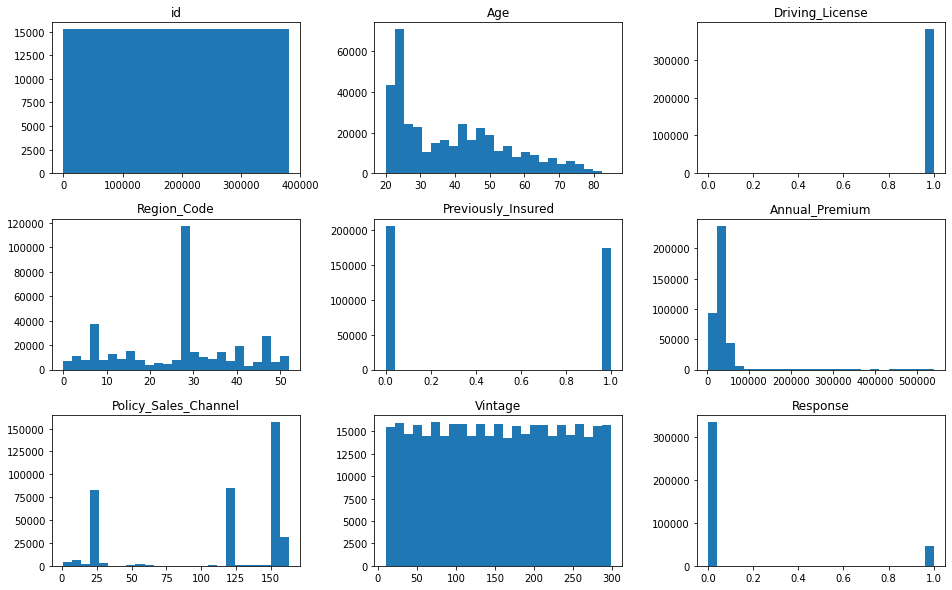

In [13]:
num_atributos.hist( grid = False, figsize = (16, 10), bins = 25 );

### 3.1.2. VARIAVEL CATEGORICA

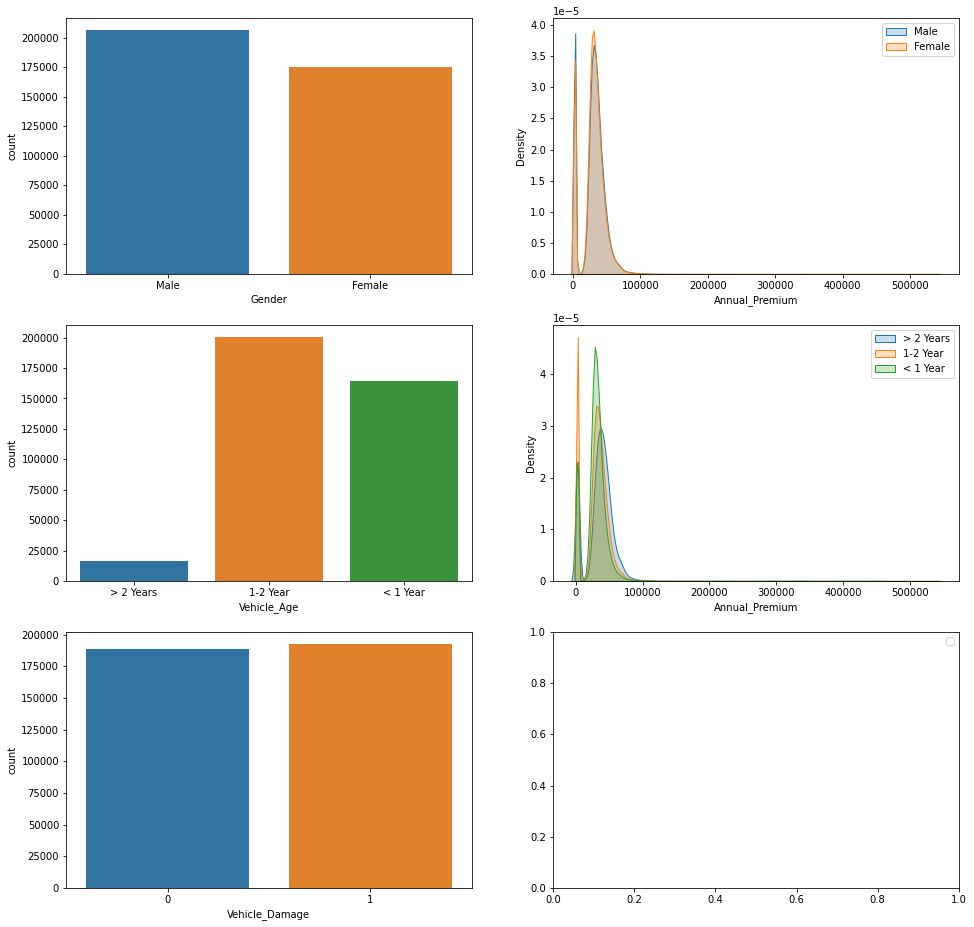

In [14]:
plt.figure( figsize = ( 16, 16 ) )
plt.subplot( 3, 2, 1 )
sns.countplot( df3['Gender'] );

plt.subplot( 3, 2, 2 )
sns.kdeplot( df3[df3['Gender'] == 'Male']['Annual_Premium'], shade = True )
sns.kdeplot( df3[df3['Gender'] == 'Female']['Annual_Premium'], shade = True )
plt.legend( labels = ['Male', 'Female'] );

plt.subplot( 3, 2, 3 )
sns.countplot( df3['Vehicle_Age'] );

plt.subplot( 3, 2, 4 )
sns.kdeplot( df3[df3['Vehicle_Age'] == '> 2 Years']['Annual_Premium'], shade = True )
sns.kdeplot( df3[df3['Vehicle_Age'] == '1-2 Year']['Annual_Premium'], shade = True )
sns.kdeplot( df3[df3['Vehicle_Age'] == '< 1 Year']['Annual_Premium'], shade = True )
plt.legend( labels = ['> 2 Years', '1-2 Year', '< 1 Year'] );

plt.subplot( 3, 2, 5 )
sns.countplot( df3['Vehicle_Damage'] );

plt.subplot( 3, 2, 6 )
sns.kdeplot( df3[df3['Vehicle_Damage'] == 'Yes']['Annual_Premium'], shade = True )
sns.kdeplot( df3[df3['Vehicle_Damage'] == 'No']['Annual_Premium'], shade = True )
plt.legend( labels = ['Yes', 'No'] );

## 3.2. ANALISE BIVARIADA

### 3.2.1. 1) Deveria existir mais clientes do genero masculino com seguro de veículo do que do genero feminino

**Falso.** Apesar de representarem **45,9%** dos clientes, clientes do sexo feminino representam **50,3%** dos clientes que já possuem seguro.

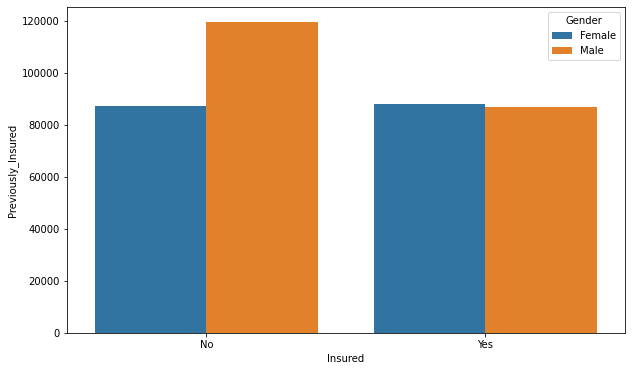

In [15]:
aux1 = df3[['Gender', 'Previously_Insured', 'Insured']].groupby( ['Insured', 'Gender'] ).count().reset_index()

plt.figure( figsize = ( 10,6 ) )
sns.barplot( x = 'Insured', y = 'Previously_Insured', hue = 'Gender', data = aux1 );



### 3.2.2. 2) Clientes do genero feminino devem possuir carros mais novos
**Verdadeiro.** Mulheres têm mais preferência por carros novos e homens por carros usados

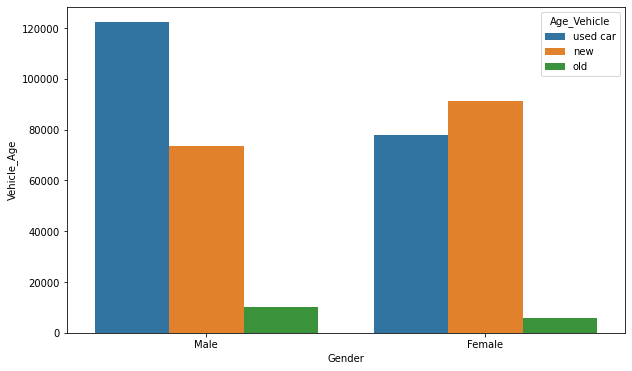

In [16]:
aux2 = df3[['Gender', 'Vehicle_Age', 'Age_Vehicle']].groupby( ['Gender', 'Age_Vehicle'] ).count().reset_index().sort_values( 'Vehicle_Age', ascending = False)

plt.figure( figsize = ( 10,6 ) )
sns.barplot( x = 'Gender', y = 'Vehicle_Age', hue = 'Age_Vehicle', data = aux2 );

### 3.2.3. 3) Clientes do genero masculino devem possuir 70% dos veículos que já se envolveram em acidentes
**Verdadeiro.** Homens possuem **58.6%** dos veículos que já se envolveram em acidentes

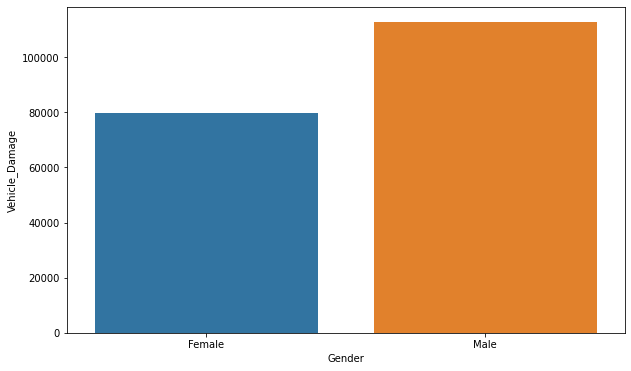

In [17]:
aux = df3[df3['Vehicle_Damage'] == 1 ]
aux3 = aux[['Gender', 'Vehicle_Damage']].groupby( 'Gender' ).count().reset_index()

plt.figure( figsize = ( 10,6 ) )
sns.barplot( x = 'Gender', y = 'Vehicle_Damage', data = aux3 );

### 3.2.4. 4) Clientes do sexo feminino deveriam ter mais interesse em adquirir o seguro do que cliente do sexo masculino

**Falso.** Apenas **10,4%** dos cliente do genero feminino tem interesse em adquirir o seguro, já **13,84%** dos cliente do genero masculino possuem interesse

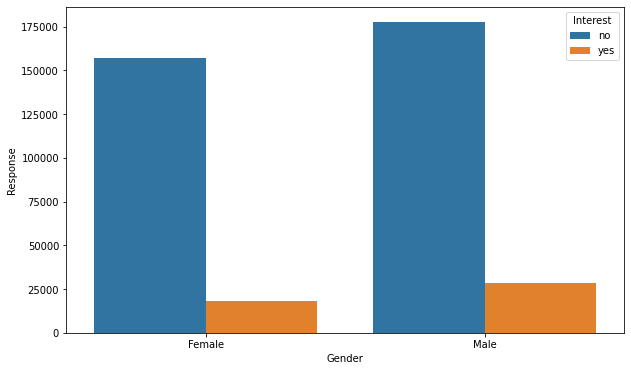

In [18]:
aux4 = df3[['Gender', 'Response', 'Interest']].groupby( ['Gender', 'Interest'] ).count().reset_index()

plt.figure( figsize = ( 10,6 ) )
sns.barplot( x = 'Gender', y = 'Response', hue = 'Interest', data = aux4 );

### 3.2.5. 5) Clientes do sexo masculino devem pagar 10% a mais de premio anual do que clientes do sexo feminino
**Falso.** Clientes do sexo masculino pagam apenas **0,41%** a mais de premio anual do que clientes do sexo feminino

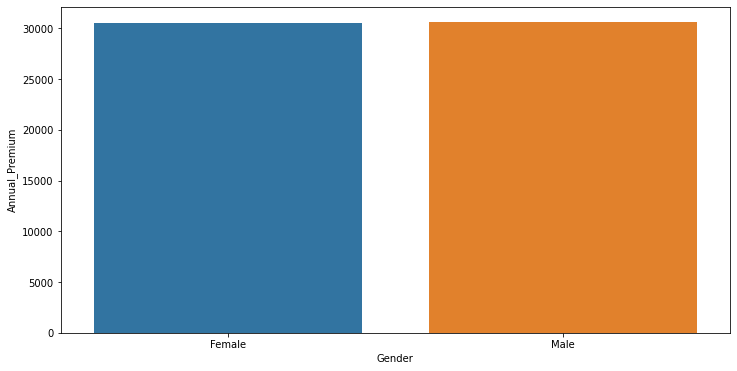

In [19]:
aux5 = df3[['Gender', 'Annual_Premium']].groupby( 'Gender' ).mean().reset_index()

plt.figure( figsize = ( 12,6 ) )
sns.barplot( x = 'Gender', y = 'Annual_Premium', data = aux5 );

### 3.2.6. 6) O percentual de clientes que possuem seguro é menor entre os mais jovens (35 ano ou menos) em relação aos clientes mais velhos
**Falso.** Apenas **30,25%** dos clientes mais velhos possuem seguro, entre os mais jovens **62%** possuem


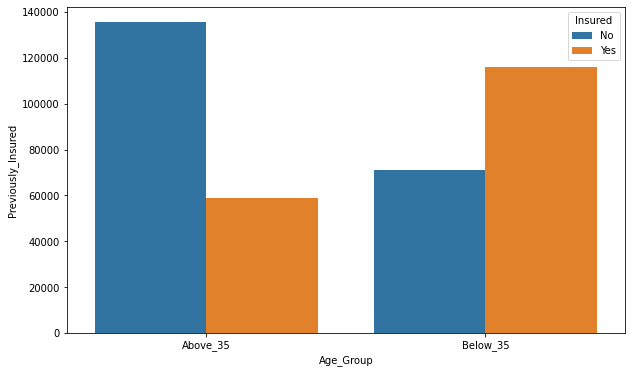

In [20]:
aux6 = df3[['Previously_Insured', 'Insured', 'Age_Group']].groupby( ['Age_Group', 'Insured'] ).count().reset_index()

plt.figure( figsize = (10, 6) )
sns.barplot( x = 'Age_Group', y = 'Previously_Insured', hue = 'Insured', data = aux6 );


### 3.2.7. 7) Clientes mais velhos (35 anos ou mais) devem possuir carros mais antigos do que cliente mais jovens
**Verdadeiro.** Clientes mais velhos e clientes mais jovens possuem preferências diferentes quanto a idade dos veículos. **91,5%** dos cliente com idade superior a 35 anos possuem carros usados. **87.78%** dos cliente cuja idade é inferior aos 35 anos possuem carros novos.

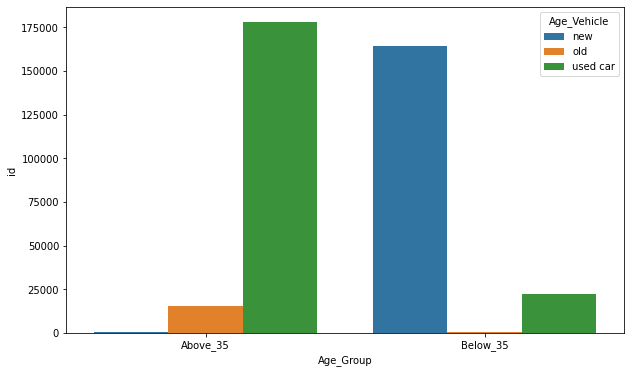

In [21]:
aux7 = df3[['Age_Group', 'Age_Vehicle', 'id']].groupby( ['Age_Group', 'Age_Vehicle'] ).count().reset_index()

plt.figure( figsize = ( 10, 6) )
sns.barplot( x = 'Age_Group', y = 'id', hue = 'Age_Vehicle', data = aux7 );

### 3.2.8. 8) Clientes com 35 anos ou menos deveriam se envolver em 70% dos acidentes.
**Falso. 67.13%** dos acidentes ocorrerem com clientes cuja idade é sunperior a 35 anos.

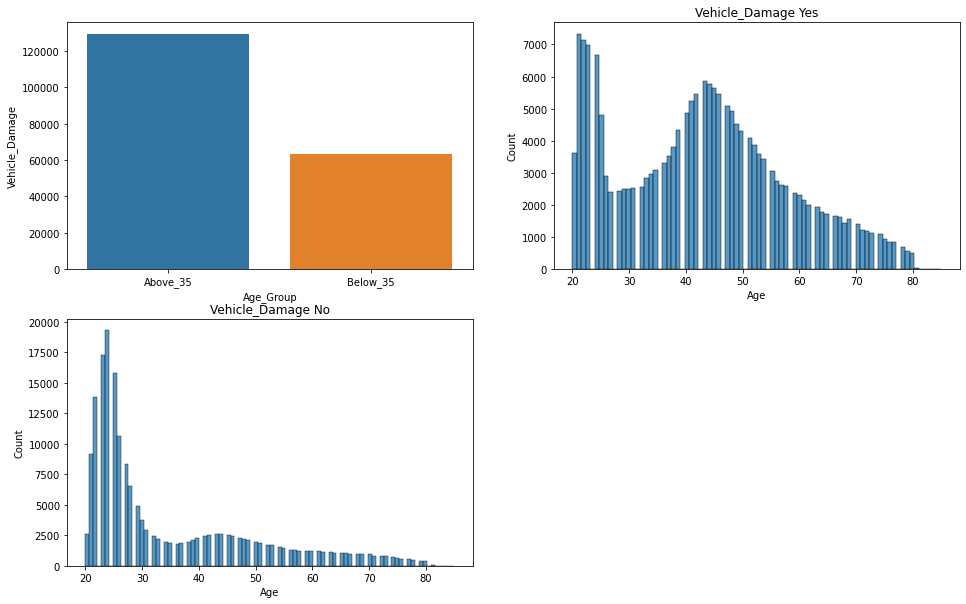

In [22]:
aux8 = df3[df3['Vehicle_Damage'] == 1 ]
aux81 = aux8[['Age_Group', 'Vehicle_Damage']].groupby( 'Age_Group' ).count().reset_index()
aux82 = df3.loc[df3['Vehicle_Damage'] == 1, 'Age']
aux83 = df3.loc[df3['Vehicle_Damage'] == 0, 'Age']

plt.figure( figsize = ( 16, 10 ) )
plt.subplot( 2, 2, 1 )
sns.barplot( x = 'Age_Group', y = 'Vehicle_Damage', data = aux81 );

plt.subplot( 2, 2, 2 )
sns.histplot( aux82 )
plt.title( 'Vehicle_Damage Yes' );

plt.subplot( 2, 2, 3 )
sns.histplot( aux83 )
plt.title( 'Vehicle_Damage No' );


In [23]:
aux82

0         44
2         47
5         24
6         23
7         56
          ..
381100    29
381101    70
381102    25
381103    47
381107    68
Name: Age, Length: 192413, dtype: int64

### 3.2.9. 9) Clientes mais velhos devem ter 10% mais interesse em adquirir o seguro do que clientes mais jovens
**Verdadeiro.** Clientes acima 35 anos representam **73,18%** dos clientes que possuem interesse em adquirir o seguro.

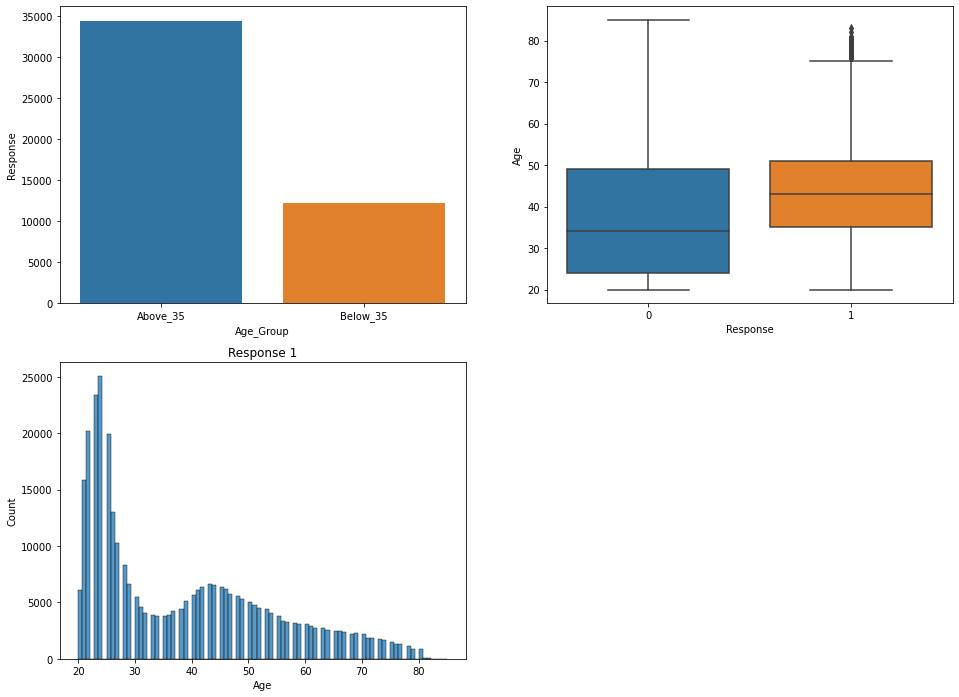

In [24]:
aux9 = df3[df3['Response'] == 1]
aux91 = aux9[['Age_Group', 'Response']].groupby( 'Age_Group' ).count().reset_index()
aux92 = df3.loc[df3['Response'] == 0, 'Age']
aux93 = df3.loc[df3['Response'] == 1, 'Age']

plt.figure( figsize = ( 16, 12 ) )
plt.subplot( 2, 2, 1 )
sns.barplot( x = 'Age_Group', y = 'Response', data = aux91 );

plt.subplot( 2, 2, 2 )
sns.boxplot( x = 'Response', y = 'Age', data = df3 );

plt.subplot( 2, 2, 3 )
sns.histplot( aux92 )
plt.title( "Response 1" );


### 3.2.10. 10) Dos clientes que já possuem seguro, 80% não têm interesse em adquirir outro seguro
**Verdadeiro.** Dos clientes que já possuem seguro, **99,91%** não têm interesse em adquirir outro seguro. Dos que não possuem, **22,54%** possuem interesse.

Response                   0         1
Previously_Insured                    
0                   0.774546  0.225454
1                   0.999095  0.000905


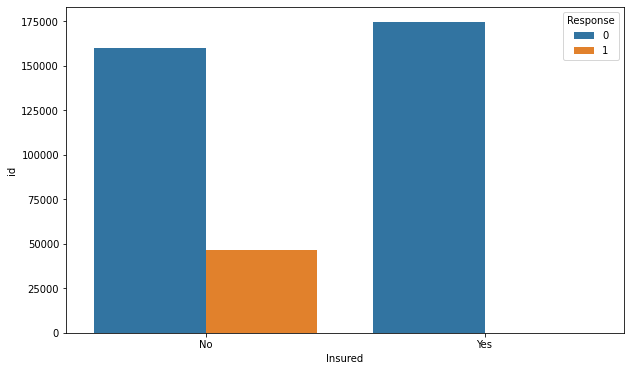

In [25]:
aux10 = df3[['Insured', 'Response', 'id']].groupby( ['Insured', 'Response'] ).count().reset_index()
print(pd.crosstab( df3['Previously_Insured'], df3['Response'] ).apply( lambda x: x / x.sum(), axis = 1 ))

plt.figure( figsize = ( 10, 6 ) )
sns.barplot( x = 'Insured', y = 'id', hue = 'Response', data = aux10 );

### 3.2.11. 11) Clientes a menos tempo como cliente, possuem 20% mais interesse em adquirir o seguro
**Falso.** Clientes a mais tempo como clientes possuem mais interesse em adquirir o seguro do que clientes a menos tempo, **52,95%, 47,05%**, respectivamente.

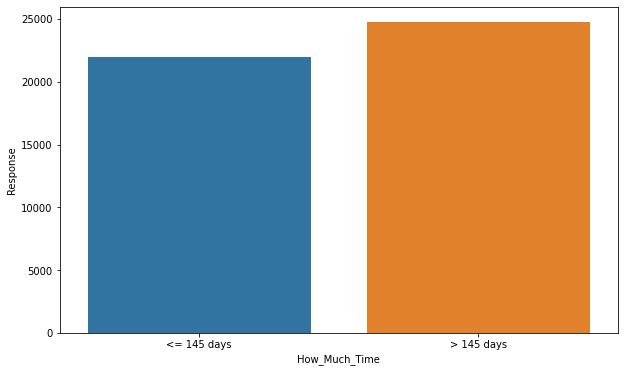

In [26]:
aux11 = df3[df3['Response'] == 1]

aux111 = aux11[['How_Much_Time', 'Response']].groupby( 'How_Much_Time' ).count().reset_index()

plt.figure( figsize = ( 10, 6 ) )
sns.barplot( x = 'How_Much_Time', y = 'Response', data = aux111 );

### 3.2.12. 12) Clientes com Veiculos mais novos possuem mais interesse em adquirir o seguro
**Falso.** 
- Dos clientes que possuem carros novos **4,37%** possuem interesse. 
- Dos clientes que possuem carros usados **29,39%** possuem interesse. 
- Dos clientes que possuem carros velhos **17,37%**

  Age_Vehicle  Response      id
0         new         0  157584
1         new         1    7202
2         old         0   11305
3         old         1    4702
4    used car         0  165510
5    used car         1   34806


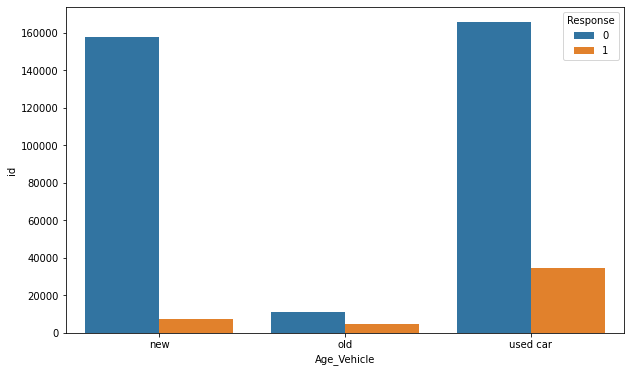

In [27]:
aux12 = df3[['Age_Vehicle', 'Response', 'id']].groupby( ['Age_Vehicle', 'Response'] ).count().reset_index()
print(aux12)

plt.figure( figsize = ( 10, 6 ) )
sns.barplot( x = 'Age_Vehicle', y = 'id', hue = 'Response', data = aux12 );

# 4.0. PREPARACAO DOS DADOS

In [28]:
df4 = df3.copy()
df4 = df4[['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']]

## 4.1. TREINO E TEST

In [29]:
x = df4.drop( 'Response', axis = 1 )
y = df4['Response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split( x, y, test_size = 0.20)

df4 = pd.concat( [x_train, y_train], axis = 1 )

## 4.2. NORMALIZACAO

In [30]:
# annual_premium
ss = pp.StandardScaler()

df4['Annual_Premium'] = ss.fit_transform( df4[['Annual_Premium']].values )

## 4.3. RESCALING

In [31]:
mm_age = pp.MinMaxScaler()
mm_vintage = pp.MinMaxScaler()

#age
df4['Age'] = mm_age.fit_transform( df4[['Age']].values )

#vintage
df4['Vintage'] = mm_vintage.fit_transform( df4[['Vintage']].values )


## 4.4. ENCODER

In [32]:
#gender - target enconding
target_encoding_gender = df4.groupby( 'Gender' )['Response'].mean()
df4.loc[:, 'Gender'] = df4['Gender'].map( target_encoding_gender )

# region_code - Quando há muitos niveis na variável categórica +6 usar target encoding 
target_encoding_region_encoding = df4.groupby( 'Region_Code' )['Response'].mean()
df4.loc[:, 'Region_Code'] = df4['Region_Code'].map( target_encoding_region_encoding )

# vehicle_age - One Hot Encoding ou Order Encoding 
df4 = pd.get_dummies( df4, prefix= 'Vehicle_Age', columns = ['Vehicle_Age'] )

# policy_sales_channel Targer encoding / Frequency encoding
fe_policy_sales_channel = df4.groupby( 'Policy_Sales_Channel' ).size() / len( df4 )
df4.loc[:, 'Policy_Sales_Channel'] = df4['Policy_Sales_Channel'].map( fe_policy_sales_channel )

## 4.5. TEST PREPARATION

In [33]:
#annual_premium
x_validation['Annual_Premium'] = ss.fit_transform( x_validation[['Annual_Premium']].values )

#age
x_validation['Age'] = mm_age.fit_transform( x_validation[['Age']].values )

#vintage
x_validation['Vintage'] = mm_vintage.fit_transform( x_validation[['Vintage']].values )

#gender - target enconding
x_validation.loc[:, 'Gender'] = x_validation['Gender'].map( target_encoding_gender )

# region_code - Quando há muitos niveis na variável categórica +6 usar target encoding 
x_validation.loc[:, 'Region_Code'] = x_validation['Region_Code'].map( target_encoding_region_encoding )

# vehicle_age - One Hot Encoding ou Order Encoding 
x_validation= pd.get_dummies( x_validation, prefix= 'Vehicle_Age', columns = ['Vehicle_Age'] )

# policy_sales_channel Targer encoding / Frequency encoding
x_validation.loc[:, 'Policy_Sales_Channel'] = x_validation['Policy_Sales_Channel'].map( fe_policy_sales_channel )

#fillna
x_validation = x_validation.fillna( 0 )

# 5.0. FEATURE SELECTION

## 5.1. FEATURE IMPORTANCE

In [34]:
# definicao do modelo
forest = en.ExtraTreesClassifier( n_estimators= 250, random_state = 0, n_jobs = 1 )

# data preparation
x_train_n = df4.drop( ['id', 'Response'], axis = 1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=1, random_state=0)

Feature Ranking
                 feature  importances
0                Vintage     0.273954
0         Annual_Premium     0.244523
0                    Age     0.163609
0            Region_Code     0.105284
0         Vehicle_Damage     0.070201
0   Policy_Sales_Channel     0.060563
0     Previously_Insured     0.054477
0   Vehicle_Age_< 1 Year     0.013570
0   Vehicle_Age_1-2 Year     0.006034
0                 Gender     0.004954
0  Vehicle_Age_> 2 Years     0.002316
0        Driving_License     0.000515


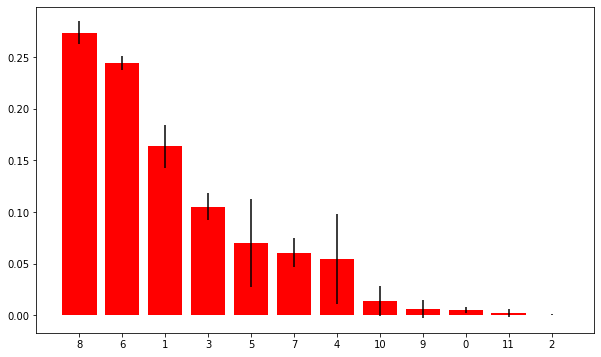

In [35]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0 )
indices = np.argsort( importances )[::-1]

#print ranking das features
print( 'Feature Ranking' )
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importances': j}, index = [0] )
    df = pd.concat( [df, aux], axis = 0 )
    
print( df.sort_values( 'importances', ascending = False ) )

# plot da importancia das features baseda na imporeza da forest
plt.figure( figsize = ( 10, 6 ))
plt.bar( range( x_train_n.shape[1] ), importances[indices], color = 'r', yerr = std[indices], align = 'center'  )
plt.xticks( range( x_train_n.shape[1] ), indices )
plt.xlim( [-1, x_train_n.shape[1]] )
plt.show()

# 6.0 MACHINE LEARNING

In [36]:
cols_selected = ['Vintage', 'Annual_Premium', 'Age', 'Region_Code', 'Vehicle_Damage',
                 'Policy_Sales_Channel', 'Previously_Insured']

x_train = df4[cols_selected]
x_test = x_validation[cols_selected]
y_test = y_validation.copy()

## 6.1. KNN

In [37]:
#definição do modelo
knn_model = nh.KNeighborsClassifier( n_neighbors = 7 )

#treino do modelo
knn_model.fit( x_train, y_train )

#predição do modelo - poder de generalização
yhat_knn = knn_model.predict_proba( x_test )

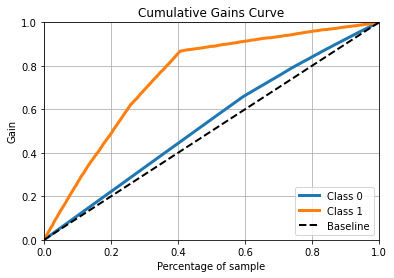

In [38]:
#cumulative gain curve
skplt.metrics.plot_cumulative_gain( y_test, yhat_knn );

- Com **20%** da base ordenada é possível atingir **50%** dos clientes interessados

- Com **40%** da base ordenada é possível atingir **85%** dos clientes interessados

## 6.2. LINEAR REGRESSOR

In [39]:
#definicao do modelo
lr_model = lm.LogisticRegression( random_state = 0 )

#treino do modelo
lr_model.fit( x_train, y_train )

#predicao do modelo
yhat_lr = lr_model.predict_proba( x_test )

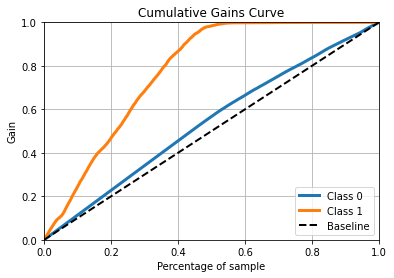

In [40]:
#cumulative gain curve
skplt.metrics.plot_cumulative_gain( y_test, yhat_lr );

- Com **20%** da base ordenada é possível alcançar **45%** dos clientes interessados
- Com **50%** da base ordenada é possível alcançar praticamente **100%** dos clientes interessados

## 6.3. RANDOM FOREST

In [41]:
#definicao do modelo
rf_model = en.RandomForestClassifier()

#treino do modelo
rf_model.fit( x_train, y_train )

#predicao do modelo 
yhat_rf = rf_model.predict_proba( x_test )

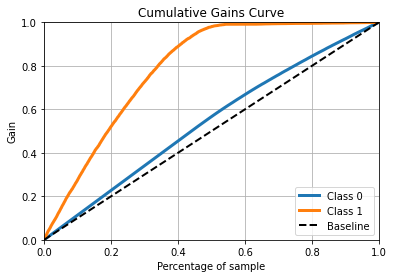

In [42]:
#cumulative gain curve
skplt.metrics.plot_cumulative_gain( y_test, yhat_rf );

- Com **20%** da base ordenada é possível atingir **55%** dos clientes interessados
- Com **50%** da base ordenada é possível atingir praticamente **100%** dos clientes interessados

## 6.4. XGBoost

In [43]:
#definicao do modelo
xgb_model = xgb.XGBClassifier( objective = 'binary:logistic',
                               n_estimators = 100,
                               eval_metric = "logloss")

#treino do modelo
xgb_model.fit( x_train, y_train )

#predicao do modelo
yhat_xgb = xgb_model.predict_proba( x_test )

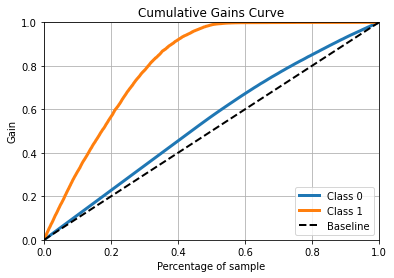

In [44]:
#cumulative gain curve
skplt.metrics.plot_cumulative_gain( y_test, yhat_xgb );

- Com **20%** da base ordenada é possível atingit praticamente **60%** dos clientes interessados
- Com **50%** da base ordenada é possível atingir praticamente **100%** dos clientes interessados

## 6.5. EXTRA TREES

In [45]:
#model definition
et = en.ExtraTreesClassifier( n_estimators = 100, n_jobs = -1, random_state = 42 )

#treinamento do modelo
et.fit( x_train, y_train )

#predicao do modelo
yhat_et = et.predict_proba( x_test )

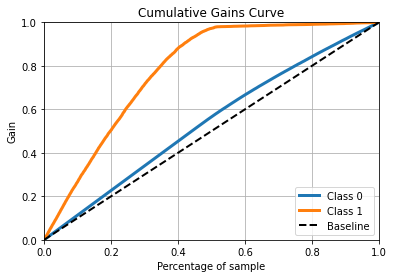

In [46]:
skplt.metrics.plot_cumulative_gain( y_test, yhat_et );

- Com **20%** da base ordenada é possível atingit praticamente **50%** dos clientes interessados
- Com **50%** da base ordenada é possível atingir praticamente **99%** dos clientes interessados

# 7.0. MODEL PERFORMANCE

In [74]:
df7 = x_validation.copy()
df7['Response'] = y_test.copy()

#propensity score
df7['Score'] = yhat_lr[:, 1].tolist()

#sort_values by propensity score
df7 = df7.sort_values( 'Score', ascending = False )


In [75]:
def precision_at_k( data, k ):
    data = data.reset_index( drop = True )

    data['Ranking'] = data.index + 1

    data['Precision_at_k'] = data['Response'].cumsum() / data['Ranking']
    
    return data.loc[k, 'Precision_at_k']

In [76]:
def recall_at_k( data, k ):
    data = data.reset_index( drop = True )

    data['Ranking'] = data.index + 1

    data['Recall_at_k'] = data['Response'].cumsum() / data['Response'].sum()
    
    return data.loc[k, 'Recall_at_k']

In [77]:
df7 = df7.reset_index( drop = True )

df7['Ranking'] = df7.index + 1

#precision
df7['Precision_at_k'] = df7['Response'].cumsum() / df7['Ranking']

#recall
df7['Recall_at_k'] = df7['Response'].cumsum() / df7['Response'].sum()


In [78]:
precision_at_17000 = precision_at_k( df7, k = 17000 )
print( 'Precision at K: {}'.format( precision_at_17000) )

recall_at_17000 = recall_at_k( df7, k = 17000 )
print( 'Recall at K:    {}'.format( recall_at_17000) )

df7 = df7.drop( columns = 'Response' )

Precision at K: 0.280512911005235
Recall at K:    0.5146773149147421


- Entrando em contato com os primeiro 17.000 clientes ordenados pelo modelo, é possível alcançar 50% dos clientes interessados no seguro automóvel

In [86]:
df7[['id', 'Score', 'Ranking', 'Precision_at_k', 'Recall_at_k']].head(10)

,id,Score,Ranking,Precision_at_k,Recall_at_k
0,54744,0.403949,1,1.000000,0.000108
1,121688,0.361891,2,0.500000,0.000108
2,265734,0.360793,3,0.333333,0.000108
3,3781,0.350093,4,0.500000,0.000216
4,280889,0.347537,5,0.400000,0.000216
5,6748,0.347417,6,0.500000,0.000324
6,132750,0.346114,7,0.428571,0.000324
7,330832,0.346017,8,0.375000,0.000324
8,140281,0.345573,9,0.333333,0.000324
9,227348,0.345410,10,0.300000,0.000324


In [ ]:
#save
#pkl.dump( lr_model, open( 'C:/Users/Criso/repos/health_insurance_cross_sell/model/modelo_lr.pkl', 'wb' ) )